In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.metrics import F1Score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



In [2]:
df_features = pd.read_csv(filepath_or_buffer='training_data/landmarks.csv',
                 index_col='pose_id')

df_features.head()

,x_nose,y_nose,z_nose,x_left_eye_inner,y_left_eye_inner,z_left_eye_inner,x_left_eye,y_left_eye,z_left_eye,x_left_eye_outer,...,z_left_heel,x_right_heel,y_right_heel,z_right_heel,x_left_foot_index,y_left_foot_index,z_left_foot_index,x_right_foot_index,y_right_foot_index,z_right_foot_index
pose_id,,,,,,,,,,,,,,,,,,,,,
0,-5.889507,-57.637520,-45.019750,-4.656085,-62.832863,-44.571823,-3.302626,-63.386856,-44.567863,-2.032406,...,56.852562,-0.842025,35.037060,50.565020,5.842190,45.971020,50.263714,0.092779,45.842150,41.427795
1,-4.255504,-62.935925,-128.907500,-2.977403,-67.035990,-124.258545,-2.215265,-67.198250,-124.263240,-1.494903,...,-14.129170,-1.298891,54.733307,-6.886051,3.980098,65.370830,-49.023930,-5.090634,65.641780,-42.878056
2,-2.878917,-61.709988,-137.453340,-1.619050,-65.693750,-132.181660,-0.785822,-65.814340,-132.184070,-0.019743,...,-19.904400,-2.119770,51.265694,-15.554097,1.994894,62.725025,-57.717957,-4.452602,62.494457,-53.804527
3,-4.242575,-60.371220,-135.094830,-3.118133,-64.416000,-129.995930,-2.369744,-64.603290,-130.003400,-1.753780,...,-6.855729,-1.485475,59.729427,1.433403,1.950102,68.187256,-42.989098,-4.573338,68.144350,-34.117043
4,-0.805543,-56.178570,-41.124413,-0.055174,-58.501305,-37.938560,0.456936,-58.473960,-37.954430,0.969290,...,47.124107,-2.455719,52.861732,45.936783,2.699764,57.254112,27.531416,-2.288348,57.803005,26.288315


In [3]:
df_labels = pd.read_csv(filepath_or_buffer='training_data/labels.csv',
                        index_col='pose_id')
df_labels.head()

,pose
pose_id,
0,jumping_jacks_down
1,jumping_jacks_down
2,jumping_jacks_down
3,jumping_jacks_down
4,jumping_jacks_down


In [4]:
def get_model(input_size, filters=8, dropout1=0.2, dropout2=0.2, classes=10):
    model = Sequential([
        Input(shape=(input_size,)),
        Dense(filters, activation='relu'),
        Dense(filters, activation='relu'),
        Dense(filters, activation='relu'),
        Dense(filters, activation='relu'),
        BatchNormalization(),
        Dropout(dropout1),
        Dense(filters, activation='relu'),
        Dense(filters, activation='relu'),
        Dense(filters, activation='relu'),
        Dense(filters, activation='relu'),
        BatchNormalization(),
        Dropout(dropout2),
        Dense(classes, activation='softmax'),
    ])
    model.summary()

    return model

In [5]:
def stop_early(patience=10, start=50):
    earlystopping=EarlyStopping(monitor='val_f1_score',
                                patience=patience,
                                verbose=1,
                                mode='max',
                                restore_best_weights=True,
                                start_from_epoch=start)
    return earlystopping

In [6]:
df_no_poses = pd.read_csv(filepath_or_buffer='training_data/pose_landmarks_per_pose.csv').drop('Frame', axis=1)

In [7]:
df_no_poses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 719 entries, 0 to 718
Data columns (total 99 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Nose_X            719 non-null    float64
 1   Nose_Y            719 non-null    float64
 2   Nose_Z            719 non-null    float64
 3   LeftEyeInner_X    719 non-null    float64
 4   LeftEyeInner_Y    719 non-null    float64
 5   LeftEyeInner_Z    719 non-null    float64
 6   LeftEye_X         719 non-null    float64
 7   LeftEye_Y         719 non-null    float64
 8   LeftEye_Z         719 non-null    float64
 9   LeftEyeOuter_X    719 non-null    float64
 10  LeftEyeOuter_Y    719 non-null    float64
 11  LeftEyeOuter_Z    719 non-null    float64
 12  RightEyeInner_X   719 non-null    float64
 13  RightEyeInner_Y   719 non-null    float64
 14  RightEyeInner_Z   719 non-null    float64
 15  RightEye_X        719 non-null    float64
 16  RightEye_Y        719 non-null    float64
 1

In [8]:
df_no_poses['pose'] = 'no_pose'
no_pose_labels = df_no_poses.pose
df_no_poses=df_no_poses.drop('pose', axis=1)

In [9]:
df_no_poses.columns = df_features.columns
df_features = pd.concat([df_features, df_no_poses], axis=0).reset_index(drop=True)

In [10]:
df_labels = pd.concat([df_labels, no_pose_labels], axis=0).reset_index(drop=True)

In [11]:
df_labels

,pose
0,jumping_jacks_down
1,jumping_jacks_down
2,jumping_jacks_down
3,jumping_jacks_down
4,jumping_jacks_down
...,...
2086,no_pose
2087,no_pose
2088,no_pose
2089,no_pose


In [12]:
X = df_features
y = pd.get_dummies(df_labels, dtype=int)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=38, stratify=y)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [14]:
model2 = get_model(99, 64, 0.5, 0.5, 11)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         6,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 11)             │           715 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,747 (143.54 KB)

 Trainable params: 36,491 (142.54 KB)

 Non-trainable params: 256 (1.00 KB)

In [15]:
model2.compile(optimizer='adam', metrics=[F1Score(average='macro', name='f1_score')], loss='categorical_focal_crossentropy')
history2 = model2.fit(X_train, y_train, epochs=200, validation_split=0.1, callbacks=[stop_early(patience=50)])

Epoch 1/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - f1_score: 0.1616 - loss: 0.5754 - val_f1_score: 0.1491 - val_loss: 0.4320
Epoch 2/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - f1_score: 0.3227 - loss: 0.3093 - val_f1_score: 0.3197 - val_loss: 0.3530
Epoch 3/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - f1_score: 0.4282 - loss: 0.2341 - val_f1_score: 0.3695 - val_loss: 0.2768
Epoch 4/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - f1_score: 0.4608 - loss: 0.1961 - val_f1_score: 0.4495 - val_loss: 0.2094
Epoch 5/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - f1_score: 0.4995 - loss: 0.1773 - val_f1_score: 0.5142 - val_loss: 0.1556
Epoch 6/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - f1_score: 0.5395 - loss: 0.1579 - val_f1_score: 0.5298 - val_loss: 0.1203
Epoch 7/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - f1_score: 0.5323 - loss: 0.1539 - val_f1_score: 0.5940 - val_loss: 0.1083
Epoch 8/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - f1_score: 0.5763 - loss: 0.1564 - val_f1_score: 0.5657 - 

In [16]:
print(classification_report(y_true=np.argmax(y_test, axis=1),
                            y_pred=np.argmax(model2.predict(X_test), axis=1),
                            target_names=y.columns.values))

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
                         precision    recall  f1-score   support

pose_jumping_jacks_down       0.83      0.91      0.87        47
  pose_jumping_jacks_up       0.83      0.78      0.80        45
           pose_no_pose       1.00      1.00      1.00       180
      pose_pullups_down       0.78      0.90      0.83        39
        pose_pullups_up       0.80      0.71      0.75        34
      pose_pushups_down       1.00      0.88      0.94        25
        pose_pushups_up       0.90      0.97      0.93        36
        pose_situp_down       1.00      0.92      0.96        25
          pose_situp_up       0.82      0.92      0.87        25
       pose_squats_down       0.93      0.88      0.90        32
         pose_squats_up       0.62      0.57      0.60        35

               accuracy                           0.89       523
              macro avg       0.87      0.86      0.86       523
           weighted avg       0.90      0.89    

In [17]:
print(model2.history.history)

{}


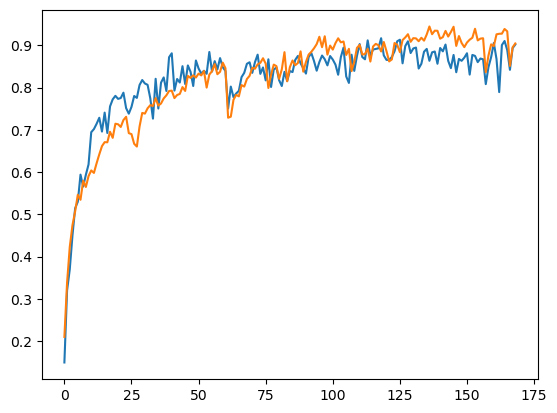

In [18]:
vf1_arr = history2.history["val_f1_score"]
f1_arr = history2.history["f1_score"]
plt.plot(range(len(vf1_arr)),vf1_arr)
plt.plot(range(len(f1_arr)),f1_arr)

In [19]:
y_res = np.argmax(model2.predict(X_test), axis=1)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [20]:
df_res = pd.DataFrame(np.argmax(model2.predict(X_test), axis=1))

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [21]:
df_res = df_res.map(lambda x:y.columns.values[x])

In [22]:
df_res

,0
0,pose_no_pose
1,pose_no_pose
2,pose_situp_up
3,pose_squats_up
4,pose_jumping_jacks_down
...,...
518,pose_pullups_up
519,pose_situp_down
520,pose_no_pose
521,pose_pushups_up


In [23]:
print(classification_report(y_true=np.argmax(y_train, axis=1),
                            y_pred=np.argmax(model2.predict(X_train), axis=1),
                            target_names=y.columns.values))

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
                         precision    recall  f1-score   support

pose_jumping_jacks_down       0.92      0.91      0.91       142
  pose_jumping_jacks_up       0.93      0.90      0.92       136
           pose_no_pose       1.00      1.00      1.00       539
      pose_pullups_down       0.88      0.98      0.93       115
        pose_pullups_up       0.98      0.97      0.98       101
      pose_pushups_down       0.97      0.92      0.95        77
        pose_pushups_up       0.96      1.00      0.98       108
        pose_situp_down       0.97      0.96      0.97        77
          pose_situp_up       1.00      1.00      1.00        74
       pose_squats_down       0.99      0.99      0.99        95
         pose_squats_up       0.86      0.81      0.83       104

               accuracy                           0.96      1568
              macro avg       0.95      0.95      0.95      1568
           weighted avg       0.96      0.96     

In [1]:
from keras.models import load_model

In [4]:
model3 = load_model('classifier.keras')

In [8]:
df_only_no_poses = pd.read_csv('~/Documents/pose_landmarks_per_pose.csv').drop("Frame", axis=1)

In [9]:
res_only_poses = np.argmax(model3.predict(df_only_no_poses), axis=1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


In [10]:
res_only_poses

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0, 10, 10, 10,  0, 10, 10, 10, 10, 10, 10,  4,  4,  4,  4,
       10,  0,  0, 10, 10, 10, 10,  4,  4, 10,  0,  0,  0,  0, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10,  4, 10, 10,  4, 10, 10,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0, 10,  0, 10,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4, 10, 10, 10, 10,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4, 10, 10, 10, 10, 10, 10,  4,  4, 10, 10, 10, 10, 10,
        4,  4,  9,  9,  0,  0,  0,  0,  9,  9,  9,  9,  0,  4,  4, 10,  4,
        4,  4,  4,  4,  4,  4,  4,  0,  0,  0,  0,  0,  0])

AttributeError: 'Sequential' object has no attribute 'predict_classes'

In [1]:
['0']*11

['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']

In [ ]:
import os

for root, dirs, files in os.walk('images/'):
    print(dirs[0])

['plank', 'push up', 'squat', 'pull up']
[]
[]
[]
[]
